In [36]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [37]:
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

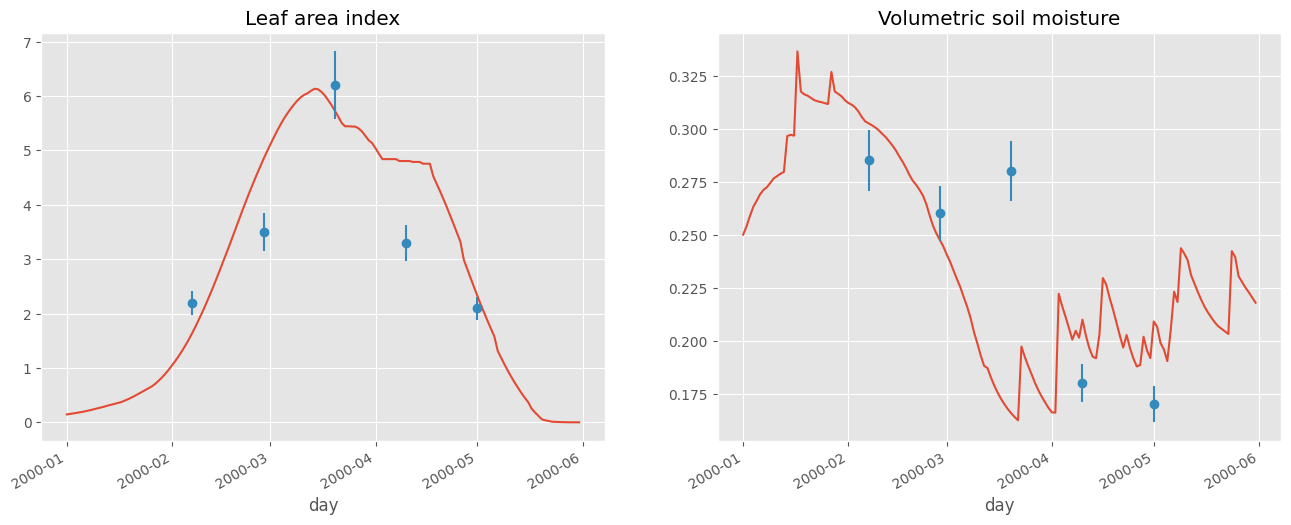

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

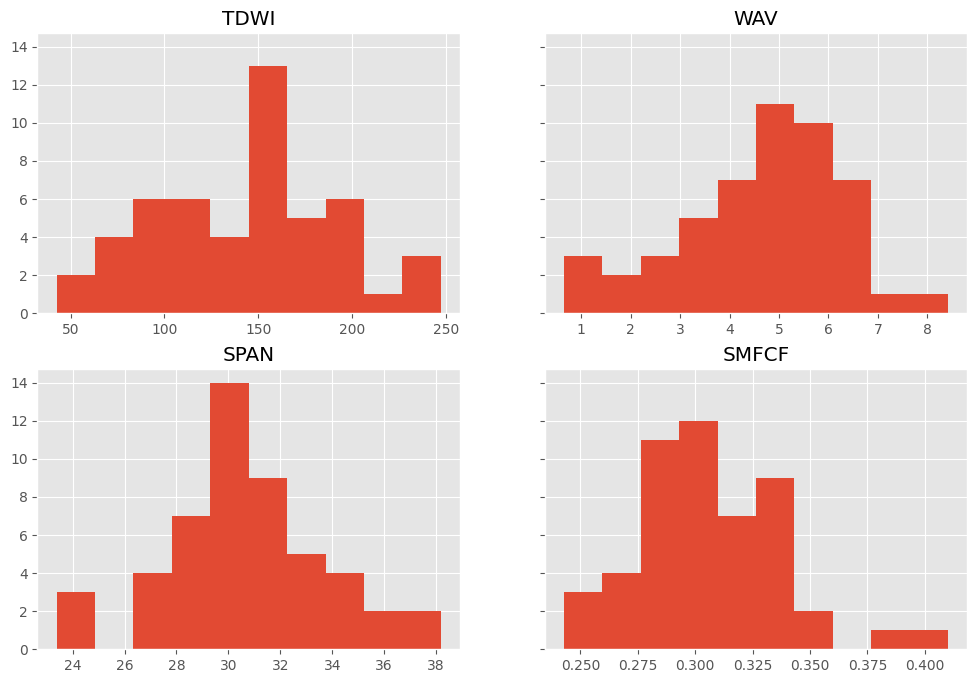

In [130]:
ensemble_size = 50
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

In [131]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

In [132]:
from river import time_series

ml_ensemble = []
for i in range(ensemble_size):
    model = time_series.SNARIMAX(
        p=1,
        q=1,
        d=1,
        sd=1
    )
    ml_ensemble.append(model)

In [133]:
from river import metrics
metrics_list = [
    metrics.MAPE()
    for _ in range(ensemble_size)
]

preds = [
    list()
    for _ in range(ensemble_size)
]

In [134]:
show_output = True

for day in enumerate(df.index):
    total_metric = 0
    for i, member in enumerate(ensemble):
        member.run(1)
        model = ml_ensemble[i]
        metric = metrics_list[i]
        LAI = member.get_variable("LAI")
        forecasted_lai = model.forecast(horizon=1)[0]

        if LAI is None or forecasted_lai is None:
            continue
        model.learn_one(LAI)
        metric.update(LAI, forecasted_lai)

        preds[i].append({
            "day": day[1].strftime('%Y-%m-%d'),
            "LAI": forecasted_lai
        })
        total_metric += metric.get()

    print(day)
    print(total_metric / ensemble_size)

(0, datetime.date(2000, 1, 1))
100.0
(1, datetime.date(2000, 1, 2))
93.83491910553876
(2, datetime.date(2000, 1, 3))
62.57132339012927
(3, datetime.date(2000, 1, 4))
47.10610331617519
(4, datetime.date(2000, 1, 5))
37.76251124383723
(5, datetime.date(2000, 1, 6))
31.586027119279496
(6, datetime.date(2000, 1, 7))
27.160125831261702
(7, datetime.date(2000, 1, 8))
23.79868882482367
(8, datetime.date(2000, 1, 9))
21.177141333890567
(9, datetime.date(2000, 1, 10))
19.109946852264066
(10, datetime.date(2000, 1, 11))
17.374287362288957
(11, datetime.date(2000, 1, 12))
15.995303574572835
(12, datetime.date(2000, 1, 13))
14.832177711321584
(13, datetime.date(2000, 1, 14))
13.783573499433823
(14, datetime.date(2000, 1, 15))
12.887481629091843
(15, datetime.date(2000, 1, 16))
12.098511785044376
(16, datetime.date(2000, 1, 17))
11.52018631823908
(17, datetime.date(2000, 1, 18))
10.919712524962344
(18, datetime.date(2000, 1, 19))
10.364049269861574
(19, datetime.date(2000, 1, 20))
9.872131882403453

In [135]:
results = [pd.DataFrame(member.get_output()) for member in ensemble]

In [136]:
pred_dfs = [
    pd.DataFrame(pred)
    for pred in preds
] 

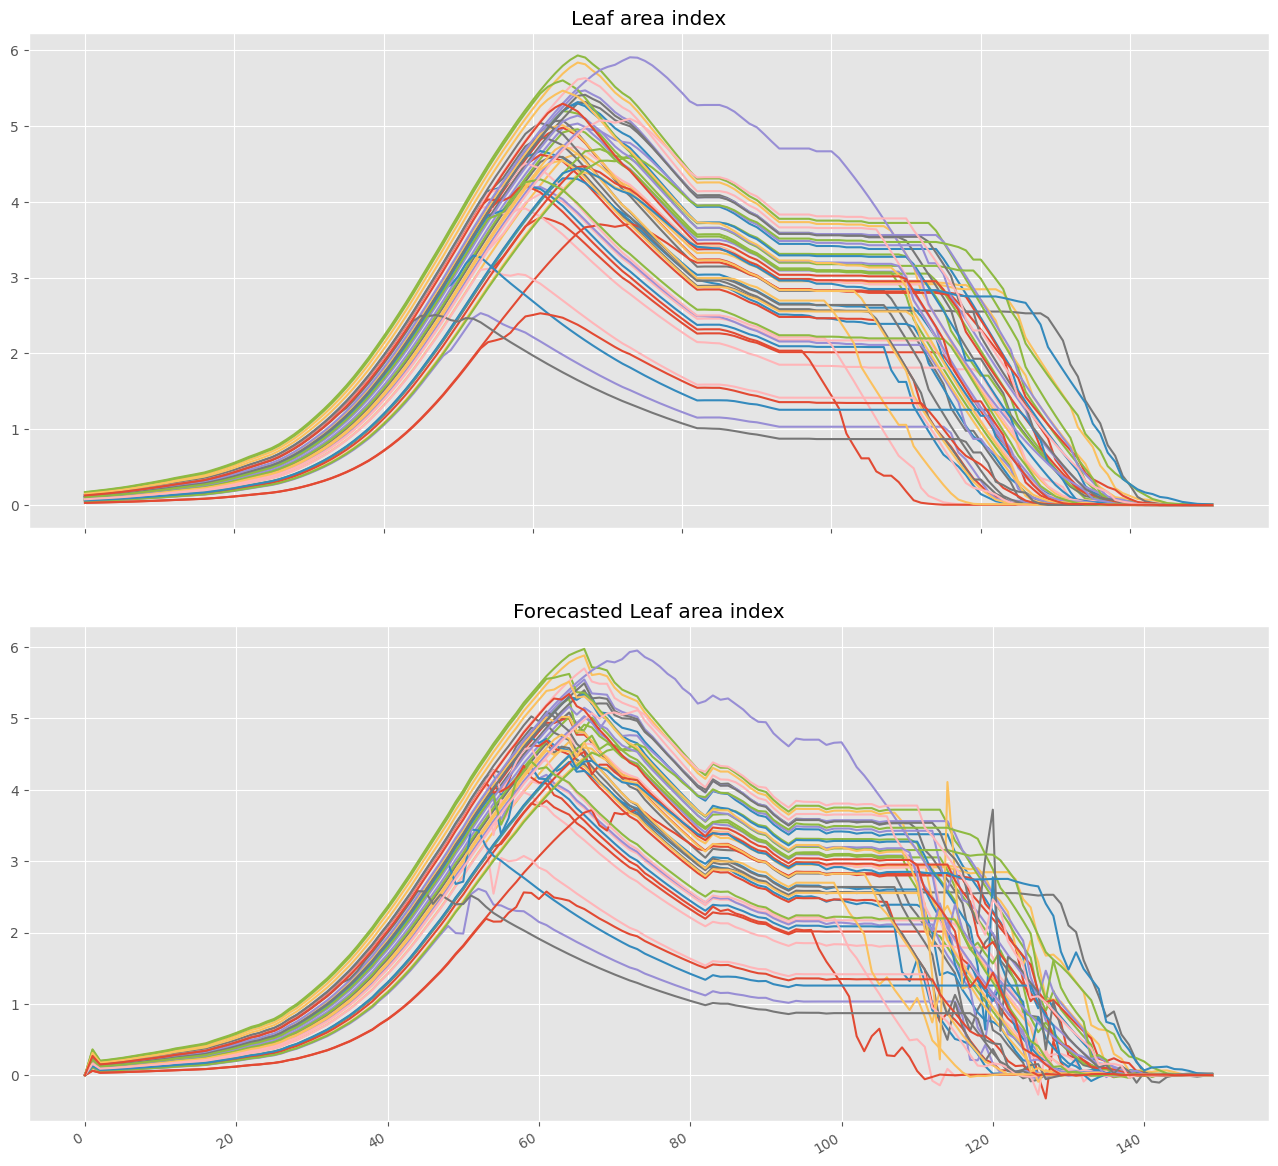

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
for i, member_df in enumerate(results):
    pred_df = pred_dfs[i]
    member_df["LAI"].plot(ax=axes[0])
    pred_df["LAI"].plot(ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Forecasted Leaf area index")
fig.autofmt_xdate()

In [138]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.75)

agg = {'LAI': [q1, q2, q3]}

combined_results = pd.concat(results).groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]
combined_pred_dfs = pd.concat(pred_dfs).groupby('day').agg(agg)
combined_pred_dfs.columns = ['_'.join(col) for col in combined_pred_dfs.columns]

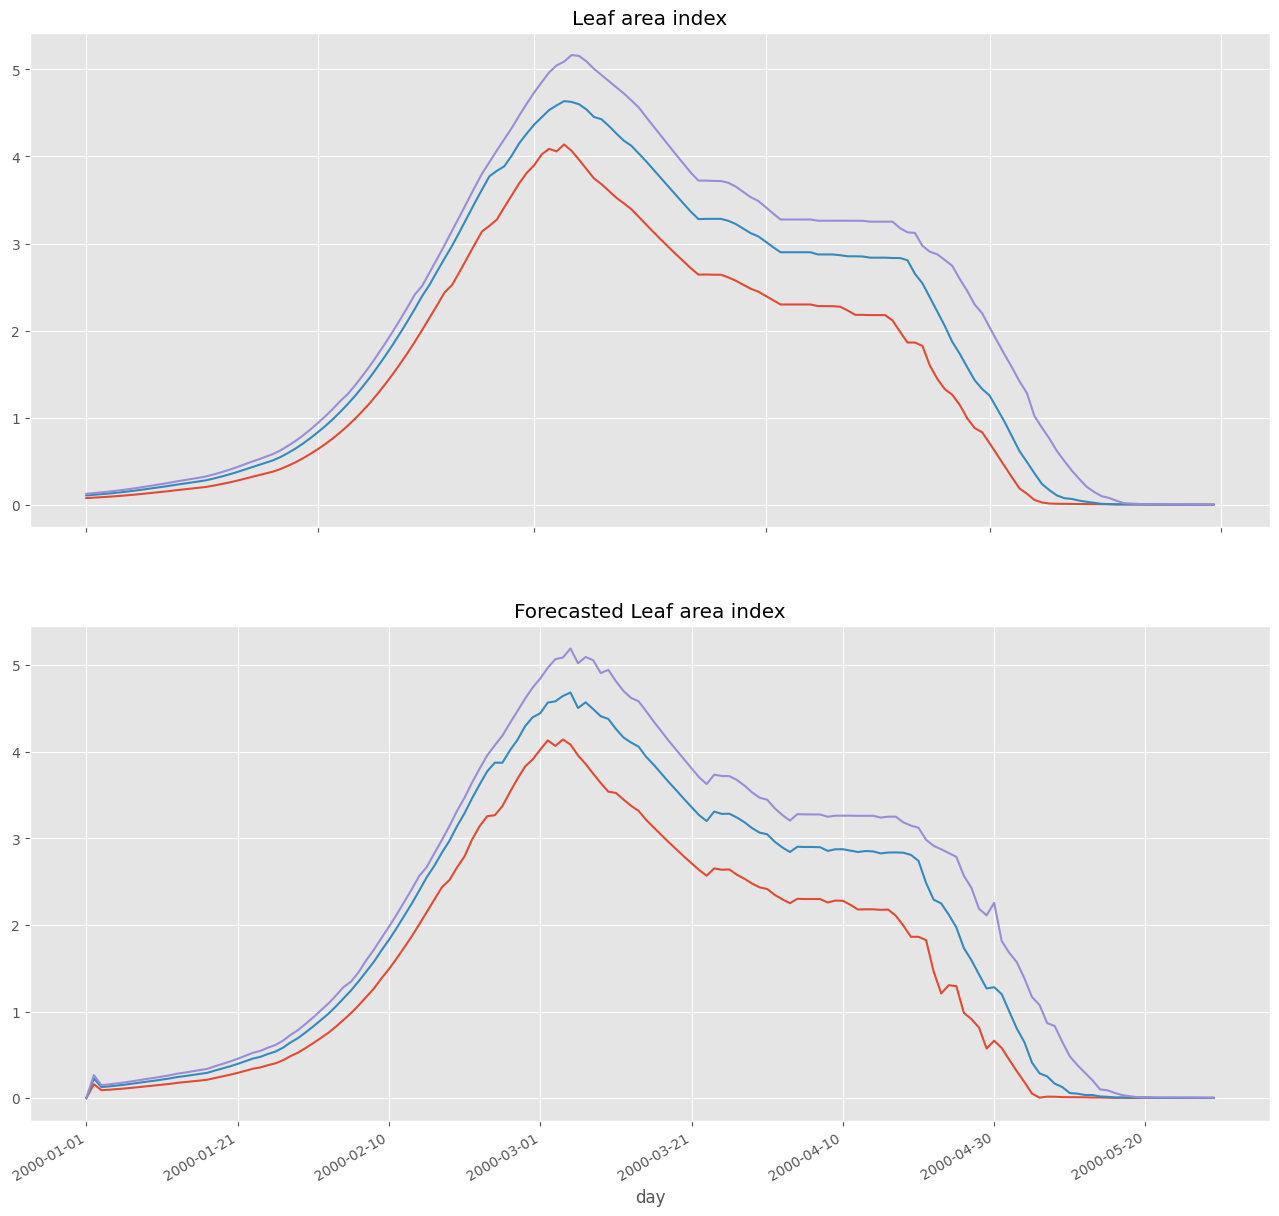

In [139]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
combined_results["LAI_q1"].plot(ax=axes[0])
combined_results["LAI_q2"].plot(ax=axes[0])
combined_results["LAI_q3"].plot(ax=axes[0])
combined_pred_dfs["LAI_q1"].plot(ax=axes[1])
combined_pred_dfs["LAI_q2"].plot(ax=axes[1])
combined_pred_dfs["LAI_q3"].plot(ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Forecasted Leaf area index")
fig.autofmt_xdate()